In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# Imports Keras (la nouvelle façon)
Sequential = tf.keras.models.Sequential
Conv1D = tf.keras.layers.Conv1D
MaxPooling1D = tf.keras.layers.MaxPooling1D
Flatten = tf.keras.layers.Flatten
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout
BatchNormalization = tf.keras.layers.BatchNormalization
Adam = tf.keras.optimizers.Adam
AUC = tf.keras.metrics.AUC

# Ajoute le dossier parent au 'path' pour trouver 'src'
sys.path.append('../src')
from src.preprocess import normalize_flux

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.20.0


In [3]:
TRAIN_PATH = '../data/raw/train.csv'
TEST_PATH = '../data/raw/test.csv'

print("Chargement des données...")
df_train = pd.read_csv(TRAIN_PATH)
df_test = pd.read_csv(TEST_PATH)

df_train['LABEL'] = df_train['LABEL'].map({1: 0, 2: 1})
df_test['LABEL'] = df_test['LABEL'].map({1: 0, 2: 1})

X_train_raw = df_train.drop('LABEL', axis=1)
y_train = df_train['LABEL']
X_test_raw = df_test.drop('LABEL', axis=1)
y_test = df_test['LABEL']

X_train_filled = X_train_raw.fillna(0)
X_test_filled = X_test_raw.fillna(0)

print("Normalisation (detrending) des données...")
X_train_normalized = X_train_filled.apply(normalize_flux, axis=1).values
X_test_normalized = X_test_filled.apply(normalize_flux, axis=1).values
print("Normalisation terminée.")

# --- 2. Préparation pour le CNN ---
print("Préparation des données pour le CNN...")
X_train_cnn = X_train_normalized[:, :, np.newaxis]
X_test_cnn = X_test_normalized[:, :, np.newaxis]

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}

print(f"Shape de X_train_cnn: {X_train_cnn.shape}")
print(f"Poids des classes: {class_weight_dict}")
print("--- Préparation terminée ---")

Chargement des données...
Normalisation (detrending) des données...
Normalisation terminée.
Préparation des données pour le CNN...
Shape de X_train_cnn: (5087, 3197, 1)
Poids des classes: {0: np.float64(0.5036633663366337), 1: np.float64(68.74324324324324)}
--- Préparation terminée ---


In [4]:
INPUT_SHAPE = (X_train_cnn.shape[1], 1) # (3197, 1)

model_v2 = Sequential([
    # ---- 1er Bloc Convolutif (Plus petit) ----
    Conv1D(filters=8, kernel_size=5, activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # ---- 2e Bloc Convolutif (Plus petit) ----
    Conv1D(filters=16, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # ---- 3e Bloc Convolutif (Plus petit) ----
    Conv1D(filters=32, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),

    # ---- Tête de Classification (Plus petite) ----
    Flatten(),

    # Couche Dense (Plus petite)
    Dense(32, activation='relu'),

    # Dropout (Plus fort)
    Dropout(0.6), # <--- Augmenté de 0.5 à 0.6

    # Couche de Sortie (Sigmoid)
    Dense(1, activation='sigmoid')
])

# Affiche un résumé de notre modèle
model_v2.summary()

C:\Users\libra\IdeaProjects\exoplanet-detection-ml\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 3193, 8)        │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 1596, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1596, 8)        │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1592, 16)       │           656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 796, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 796, 16)        │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 792, 32)        │         2,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 396, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 396, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12672)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       405,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 409,089 (1.56 MB)

 Trainable params: 408,977 (1.56 MB)

 Non-trainable params: 112 (448.00 B)

In [5]:
print("Compilation du modèle v2...")
pr_auc_metric = AUC(curve='PR', name='pr_auc')

model_v2.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', pr_auc_metric]
)

print("Début de l'entraînement v2...")

# On entraîne plus longtemps (15 epochs)
history_v2 = model_v2.fit(
    X_train_cnn,
    y_train,
    epochs=15, # <--- 15 au lieu de 10
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    class_weight=class_weight_dict
)

print("Entraînement v2 terminé.")

Compilation du modèle v2...
Début de l'entraînement v2...
Epoch 1/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.6401 - loss: 2.6175 - pr_auc: 0.0097 - val_accuracy: 0.9895 - val_loss: 0.3768 - val_pr_auc: 0.0098
Epoch 2/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.4122 - loss: 1.4175 - pr_auc: 0.0142 - val_accuracy: 0.0439 - val_loss: 0.9029 - val_pr_auc: 0.0087
Epoch 3/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.5858 - loss: 0.9349 - pr_auc: 0.0632 - val_accuracy: 0.0140 - val_loss: 1.4056 - val_pr_auc: 0.0176
Epoch 4/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.6308 - loss: 0.9553 - pr_auc: 0.0324 - val_accuracy: 0.0175 - val_loss: 1.5567 - val_pr_auc: 0.0149
Epoch 5/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.6599 - loss: 0.6802 - pr_auc: 0.0530 - val_accuracy: 0.0158 - val_loss: 1.4596 - val_pr_auc: 0.0124
Epoch 6/15
159/159 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - accuracy: 0.8341 - loss: 0.5446 - pr_auc: 0.0830 - v

In [6]:
# --- 5. Évaluation du Modèle v2 ---

print("Évaluation du modèle v2 sur le set de test...")

# 1. Obtenir les probabilités brutes
y_pred_proba_cnn_v2 = model_v2.predict(X_test_cnn).flatten()

# 2. Convertir les probabilités en classes (seuil de 0.5)
y_pred_cnn_v2 = (y_pred_proba_cnn_v2 > 0.5).astype(int)

# 3. Matrice de Confusion
print("\nMatrice de Confusion (CNN v2):")
cm_cnn_v2 = confusion_matrix(y_test, y_pred_cnn_v2)
print(cm_cnn_v2)

# 4. Rapport de Classification
print("\nRapport de Classification (CNN v2):")
print(classification_report(y_test, y_pred_cnn_v2, target_names=['Pas de Planète (0)', 'Planète (1)']))

Évaluation du modèle v2 sur le set de test...
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

Matrice de Confusion (CNN v2):
[[  7 558]
 [  0   5]]

Rapport de Classification (CNN v2):
                    precision    recall  f1-score   support

Pas de Planète (0)       1.00      0.01      0.02       565
       Planète (1)       0.01      1.00      0.02         5

          accuracy                           0.02       570
         macro avg       0.50      0.51      0.02       570
      weighted avg       0.99      0.02      0.02       570



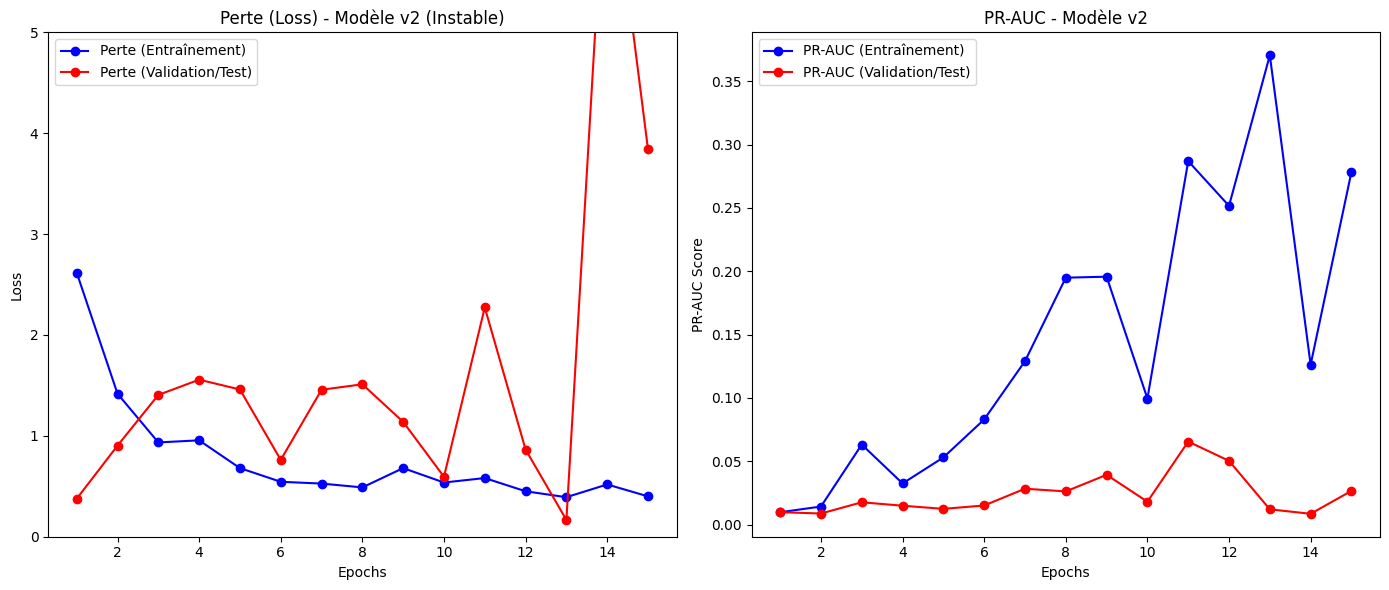

In [7]:
history_dict = history_v2.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
pr_auc = history_dict['pr_auc']
val_pr_auc = history_dict['val_pr_auc']
epochs = range(1, len(loss) + 1)

# --- 1. Graphique de la Perte (Loss) ---
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Perte (Entraînement)')
plt.plot(epochs, val_loss, 'ro-', label='Perte (Validation/Test)')
plt.title('Perte (Loss) - Modèle v2 (Instable)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim(0, 5) # On limite l'axe Y pour mieux voir (sinon Epoch 14 écrase tout)

# --- 2. Graphique de la Métrique Clé (PR-AUC) ---
plt.subplot(1, 2, 2)
plt.plot(epochs, pr_auc, 'bo-', label='PR-AUC (Entraînement)')
plt.plot(epochs, val_pr_auc, 'ro-', label='PR-AUC (Validation/Test)')
plt.title('PR-AUC - Modèle v2')
plt.xlabel('Epochs')
plt.ylabel('PR-AUC Score')
plt.legend()

plt.tight_layout()
plt.show()